In [1]:
import pandas as pd
import numpy as np
import os
import sys

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export, stats

pd.set_option('display.max_columns', None)

import matplotlib as mpl

import seaborn as sns

#xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

#keep track of 1000 bootstraps
from tqdm.notebook import tqdm

#time counter
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime


# Evaluation of models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

# #display all outputs
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

#pretty
mpl.rcParams['pdf.fonttype'] = 42  # edit-able in illustrator
mpl.rcParams['font.sans-serif'] = 'Arial'
pd.set_option('display.max_columns', None)

from tqdm.notebook import tqdm

time: 2.41 ms (started: 2022-09-19 14:06:09 -05:00)


/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '32_xgboost'    # name of notebook

def dump_table(df, name):
    export.full_frame(
        user, 
        f'{outfolder}/{name}', 
        df, 
        index=True,
        date=True
    )

def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}',
    )

time: 617 µs (started: 2022-09-19 14:07:17 -05:00)


In [2]:
worsttwo = pd.read_csv(
    inout.get_material_path('general/31_worst_two/data_worsttwo_adjudicated_220919_1405.csv.gz'), 
    index_col=0)

time: 19.2 ms (started: 2022-09-19 14:06:25 -05:00)


In [3]:
columns_to_keep = [
       'ECMO_flag', 'Intubation_flag', 'Hemodialysis_flag',
       'CRRT_flag', 'Temperature', 'Heart_rate', 'Systolic_blood_pressure',
       'Diastolic_blood_pressure', 'Mean_arterial_pressure',
       'Norepinephrine_flag', 'Norepinephrine_rate', 'Respiratory_rate',
       'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
       'GCS_motor_response', 'GCS_verbal_response', 'RASS_score', 'PEEP',
       'FiO2', 'Plateau_Pressure', 'Lung_Compliance', 'PEEP_changes',
       'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH', 'ABG_PaCO2',
       'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
       'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
       'Bilirubin', 'CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid',
       'Procalcitonin', 'had_nonviral_vap', 'vap_indeterminate_notcured'
]

no_vap_flags = [
       'ECMO_flag', 'Intubation_flag', 'Hemodialysis_flag',
       'CRRT_flag', 'Temperature', 'Heart_rate', 'Systolic_blood_pressure',
       'Diastolic_blood_pressure', 'Mean_arterial_pressure',
       'Norepinephrine_flag', 'Norepinephrine_rate', 'Respiratory_rate',
       'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
       'GCS_motor_response', 'GCS_verbal_response', 'RASS_score', 'PEEP',
       'FiO2', 'Plateau_Pressure', 'Lung_Compliance', 'PEEP_changes',
       'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH', 'ABG_PaCO2',
       'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
       'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
       'Bilirubin', 'CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid',
       'Procalcitonin', 
]

only_had_vap_flag = [
       'ECMO_flag', 'Intubation_flag', 'Hemodialysis_flag',
       'CRRT_flag', 'Temperature', 'Heart_rate', 'Systolic_blood_pressure',
       'Diastolic_blood_pressure', 'Mean_arterial_pressure',
       'Norepinephrine_flag', 'Norepinephrine_rate', 'Respiratory_rate',
       'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
       'GCS_motor_response', 'GCS_verbal_response', 'RASS_score', 'PEEP',
       'FiO2', 'Plateau_Pressure', 'Lung_Compliance', 'PEEP_changes',
       'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH', 'ABG_PaCO2',
       'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
       'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
       'Bilirubin', 'CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid',
       'Procalcitonin', 'had_nonviral_vap',
]

both_vap_flags = [
       'ECMO_flag', 'Intubation_flag', 'Hemodialysis_flag',
       'CRRT_flag', 'Temperature', 'Heart_rate', 'Systolic_blood_pressure',
       'Diastolic_blood_pressure', 'Mean_arterial_pressure',
       'Norepinephrine_flag', 'Norepinephrine_rate', 'Respiratory_rate',
       'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
       'GCS_motor_response', 'GCS_verbal_response', 'RASS_score', 'PEEP',
       'FiO2', 'Plateau_Pressure', 'Lung_Compliance', 'PEEP_changes',
       'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH', 'ABG_PaCO2',
       'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
       'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
       'Bilirubin', 'CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid',
       'Procalcitonin', 'had_nonviral_vap', 'vap_indeterminate_notcured'
]

time: 3.19 ms (started: 2022-09-19 14:06:31 -05:00)


/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


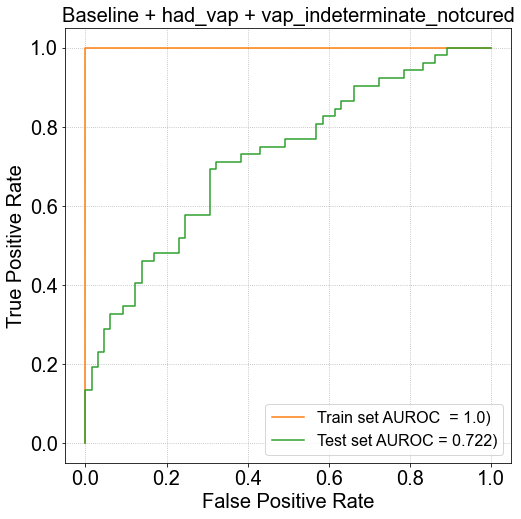

<Figure size 432x288 with 0 Axes>

time: 1.01 s (started: 2022-09-19 14:07:21 -05:00)


In [6]:
#both flags
Y=worsttwo['Binary_outcome']
X = worsttwo[columns_to_keep]

# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)

# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('Baseline + had_vap + vap_indeterminate_notcured', fontsize=20)

plt.show()

dump_figure("xgboost_both8-8-22.pdf")

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
ax = plot_importance(model)
# ax.figure.tight_layout()
fig.savefig('xgboost_both_importance8-8-22.pdf')

In [ ]:
n_boot = 1000
auc_train = []
auc_test = []

In [ ]:
from tqdm.notebook import tqdm   # For keeping track of the loop

In [ ]:
for i in tqdm(range(n_boot)):
    # This line resamples the data, without replacement
    boot_segmented = worsttwo.sample(n=len(worsttwo), replace=False, axis=0)
    
    # Then the rest of the ML pipeline is done for the resampled data
    #split into training and test sets
    X_boot = boot_segmented[columns_to_keep].values
    Y_boot = boot_segmented['Binary_outcome'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X_boot, Y_boot, test_size=0.2, random_state=0)

    #train
    model_boot = XGBClassifier()
    model_boot.fit(X_train, Y_train)
    
    # Predictions
    Y_train_preds = model_boot.predict_proba(X_train)[:,1]
    Y_test_preds = model_boot.predict_proba(X_test)[:,1]
    
    # AUCs. Collected on lists.
    fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
    auc1 = auc(fpr, tpr)
    auc_test.append(auc(fpr, tpr))
    fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
    auc2 = auc(fpr2, tpr2)
    auc_train.append(auc(fpr2, tpr2))


fig1, ax1 = plt.subplots(1,1, figsize=(11,11))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# ax1.vlines(np.mean(auc_train), 0, ax1.get_ylim()[-1],
#                 color='r', label=f"Mean AUC: {np.mean(auc_train):.3f}")

# ax1.vlines(np.percentile(auc_train, 2.5), 0, ax1.get_ylim()[-1],
#                 color='b', label=f"95% CI: {np.percentile(auc_train, 2.5):.3f}")

# ax1.vlines(np.percentile(auc_train, 97.5), 0, ax1.get_ylim()[-1],
#                 color='b', label=f"95% CI: {np.percentile(auc_train, 97.5):.3f}")

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)

plt.show()


#output cleared because very long notice log

In [ ]:

fig1, ax1 = plt.subplots(1,1, figsize=(11,11))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# ax1.vlines(np.mean(auc_train), 0, ax1.get_ylim()[-1],
#                 color='r', label=f"Mean AUC: {np.mean(auc_train):.3f}")

# ax1.vlines(np.percentile(auc_train, 2.5), 0, ax1.get_ylim()[-1],
#                 color='b', label=f"95% CI: {np.percentile(auc_train, 2.5):.3f}")

# ax1.vlines(np.percentile(auc_train, 97.5), 0, ax1.get_ylim()[-1],
#                 color='b', label=f"95% CI: {np.percentile(auc_train, 97.5):.3f}")

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)

plt.show()

ax1.figure.savefig('xgboost_both_confidence8-8-22.pdf')

In [ ]:
Y=worsttwo['Binary_outcome']
X = worsttwo[only_had_vap_flag]

# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)

# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('Baseline + had_vap', fontsize=20)

plt.show()

fig.savefig("xgboost_had_vap8-8-22.pdf")

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
ax = plot_importance(model)
# ax.figure.tight_layout()
ax.figure.savefig('xgboost_had_vap_importance8-8-22.pdf')

In [ ]:
for i in tqdm(range(n_boot)):
    # This line resamples the data, without replacement
    boot_segmented = worsttwo.sample(n=len(worsttwo), replace=False, axis=0)
    
    # Then the rest of the ML pipeline is done for the resampled data
    #split into training and test sets
    X_boot = boot_segmented[only_had_vap_flag].values
    Y_boot = boot_segmented['Binary_outcome'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X_boot, Y_boot, test_size=0.2, random_state=0)

    #train
    model_boot = XGBClassifier()
    model_boot.fit(X_train, Y_train)
    
    # Predictions
    Y_train_preds = model_boot.predict_proba(X_train)[:,1]
    Y_test_preds = model_boot.predict_proba(X_test)[:,1]
    
    # AUCs. Collected on lists.
    fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
    auc1 = auc(fpr, tpr)
    auc_test.append(auc(fpr, tpr))
    fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
    auc2 = auc(fpr2, tpr2)
    auc_train.append(auc(fpr2, tpr2))
    
    
#output cleared because very long notice log

In [ ]:

fig1, ax1 = plt.subplots(1,1, figsize=(11,11))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# ax1.vlines(np.mean(auc_train), 0, ax1.get_ylim()[-1],
#                 color='r', label=f"Mean AUC: {np.mean(auc_train):.3f}")

# ax1.vlines(np.percentile(auc_train, 2.5), 0, ax1.get_ylim()[-1],
#                 color='b', label=f"95% CI: {np.percentile(auc_train, 2.5):.3f}")

# ax1.vlines(np.percentile(auc_train, 97.5), 0, ax1.get_ylim()[-1],
#                 color='b', label=f"95% CI: {np.percentile(auc_train, 97.5):.3f}")

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)

plt.show()

ax1.figure.savefig('xgboost_had_vap_confidence8-8-22.pdf')

In [ ]:
Y=worsttwo['Binary_outcome']
X = worsttwo[no_vap_flags]

# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)

# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

# Graphing results
fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('Baseline model', fontsize=20)

plt.show()

fig.savefig("xgboost_baseline8-8-22.pdf")

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
ax = plot_importance(model)
# ax.figure.tight_layout()
ax.figure.savefig('xgboost_baseline_importance8-8-22.pdf')

In [ ]:
for i in tqdm(range(n_boot)):
    # This line resamples the data, without replacement
    boot_segmented = worsttwo.sample(n=len(worsttwo), replace=False, axis=0)
    
    # Then the rest of the ML pipeline is done for the resampled data
    #split into training and test sets
    X_boot = boot_segmented[no_vap_flags].values
    Y_boot = boot_segmented['Binary_outcome'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X_boot, Y_boot, test_size=0.2, random_state=0)

    #train
    model_boot = XGBClassifier()
    model_boot.fit(X_train, Y_train)
    
    # Predictions
    Y_train_preds = model_boot.predict_proba(X_train)[:,1]
    Y_test_preds = model_boot.predict_proba(X_test)[:,1]
    
    # AUCs. Collected on lists.
    fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
    auc1 = auc(fpr, tpr)
    auc_test.append(auc(fpr, tpr))
    fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
    auc2 = auc(fpr2, tpr2)
    auc_train.append(auc(fpr2, tpr2))
    
    
#output cleared because very long notice log

In [ ]:

fig1, ax1 = plt.subplots(1,1, figsize=(11,11))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# ax1.vlines(np.mean(auc_train), 0, ax1.get_ylim()[-1],
#                 color='r', label=f"Mean AUC: {np.mean(auc_train):.3f}")

# ax1.vlines(np.percentile(auc_train, 2.5), 0, ax1.get_ylim()[-1],
#                 color='b', label=f"95% CI: {np.percentile(auc_train, 2.5):.3f}")

# ax1.vlines(np.percentile(auc_train, 97.5), 0, ax1.get_ylim()[-1],
#                 color='b', label=f"95% CI: {np.percentile(auc_train, 97.5):.3f}")

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)


ax1.figure.savefig('xgboost_baseline_confidence8-8-22.pdf')

plt.show()